# Inter Zone Single Stream Vary Packet Size

In this experiment, we sent a single constant-bitrate (CBR) UDP stream from a node in one zone 
to a node in *another* zone and then measure the flow characteristics.
We vary the packet size and investigate how that affects the flow.

It is important to note that here, we skip the first couple tenths of a second of the flow
because there are ARP requests that happen during that time. The ARP requests do change
the measurements, but here we are interested in steady-state flow. 

It would be useful to investigate the effect of ARP in a future experiment, though.

In [26]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import json

import sys
sys.path.insert(0, '../../')
from util.metrics import StreamMetrics, StreamMetricsList

ROOT_DIRECTORY = "../../"
BASE_DIRECTORY = f"{ROOT_DIRECTORY}/results/inter-zone-single-stream/packet-size/"
SECURE_DIRECTORY = f"{BASE_DIRECTORY}/secure/"
INSECURE_DIRECTORY = f"{BASE_DIRECTORY}/insecure/"


def get_packet_sizes():
    # Assumes the sizes are the same between secure, insecure 
    # directories!
    # Directory names are of the form 'size-128', and so on.
    directories = os.listdir(SECURE_DIRECTORY)
    return sorted(
        [int(re.search(r"size-([0-9]+)", directory)[1]) 
         for directory in directories]
    )


packet_sizes = get_packet_sizes()

secure_directories = [f"{SECURE_DIRECTORY}/size-{packet_size}/"
                      for packet_size in packet_sizes]

insecure_directories = [f"{INSECURE_DIRECTORY}/size-{packet_size}/"
                        for packet_size in packet_sizes]

secure_datas = StreamMetricsList([StreamMetrics(directory)
                                  for directory in secure_directories])

insecure_datas = StreamMetricsList([StreamMetrics(directory)
                                    for directory in insecure_directories])

print(f"PACKET SIZES:\t{packet_sizes}")

print(f"SECURE LATENCIES:\t{secure_datas.mean_latency()}")
print(f"INSECURE LATENCIES:\t{insecure_datas.mean_latency()}")

print(f"SECURE THROUGHPUTS:\t{secure_datas.mean_throughput()}")
print(f"INSECURE THROUGHPUTS:\t{insecure_datas.mean_throughput()}")

print(f"SECURE JITTERS:\t{secure_datas.mean_jitter()}")
print(f"INSECURE JITTERS:\t{insecure_datas.mean_jitter()}")

print(f"SECURE DROP RATE:\t{secure_datas.drop_rate()}")
print(f"INSECURE DROP RATE:\t{insecure_datas.drop_rate()}")




PACKET SIZES:	[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450]
SECURE LATENCIES:	[3.81920e-05 5.17920e-05 6.53920e-05 7.89920e-05 9.25920e-05 1.06192e-04
 1.19792e-04 1.33392e-04 1.46992e-04 1.60592e-04 1.74192e-04 1.87792e-04
 2.01392e-04 2.14992e-04 2.28592e-04 2.42192e-04 2.55792e-04 2.69392e-04
 2.82992e-04 2.96592e-04 3.10192e-04 3.23792e-04 3.37392e-04 3.50992e-04
 3.64592e-04 3.78192e-04 3.91792e-04 4.05392e-04 4.18992e-04]
INSECURE LATENCIES:	[1.69040e-05 2.57040e-05 3.45040e-05 4.33040e-05 5.21040e-05 6.09040e-05
 6.97040e-05 7.85040e-05 8.73040e-05 9.61040e-05 1.04904e-04 1.13704e-04
 1.22504e-04 1.31304e-04 1.40104e-04 1.48904e-04 1.57704e-04 1.66504e-04
 1.75304e-04 1.84104e-04 1.92904e-04 2.01704e-04 2.10504e-04 2.19304e-04
 2.28104e-04 2.36904e-04 2.45704e-04 2.54504e-04 2.63304e-04]
SECURE THROUGHPUTS:	[62500. 62500. 62500. 62500. 62500. 62500. 62500. 62500. 62500. 6

<Figure size 2560x1920 with 0 Axes>

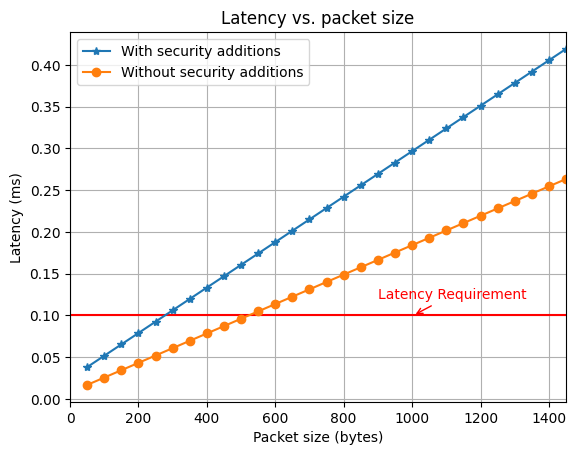

In [27]:
plt.figure(dpi=400)
fig, ax = plt.subplots()

ax.axhline(0.1, color='red')
ax.plot(packet_sizes, secure_datas.mean_latency() * 1000, '*-', label="With security additions")
ax.plot(packet_sizes, insecure_datas.mean_latency() * 1000, 'o-', label="Without security additions")
ax.annotate("Latency Requirement", xy=(1003, 0.10), xytext=(900, 0.12),
             color='red',
             arrowprops=dict(arrowstyle='->', color='red'))
ax.set_xlabel("Packet size (bytes)")
ax.set_ylabel("Latency (ms)")
ax.set_title("Latency vs. packet size")
ax.set_xbound(0, max(packet_sizes))
ax.grid()
ax.legend()
plt.show()

fig.savefig(f"{BASE_DIRECTORY}/latency.png")

The above latency graph shows how the latency of the inter-zonal stream changes with
respect to packet size. The most stringent latency threshold (0.1ms) is shown 
as a red line. The blue line shows the latency with the proposed security additions,
and the orange line shows the latency without them.

<Figure size 2560x1920 with 0 Axes>

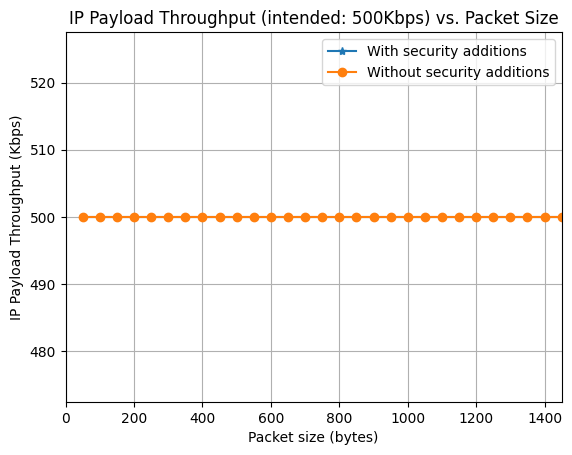

In [28]:
plt.figure(dpi=400)
fig, ax = plt.subplots()

ax.plot(packet_sizes, secure_datas.mean_throughput() / 1000 * 8, '*-', label="With security additions")
ax.plot(packet_sizes, insecure_datas.mean_throughput() / 1000 * 8, 'o-', label="Without security additions")
ax.set_xlabel("Packet size (bytes)")
ax.set_ylabel("IP Payload Throughput (Kbps)")
ax.set_title("IP Payload Throughput (intended: 500Kbps) vs. Packet Size")
ax.set_xbound(0, max(packet_sizes))
ax.grid()
ax.legend()
plt.show()

fig.savefig(f"{BASE_DIRECTORY}/throughput.png")

This shows the IP payload throughput of the data (i.e., how many bits per second
of the IP payloads are transferred every second). Here, the result is exactly 500Kbps
because the sender sent at 500Kbps and the links can support this speed. A future 
experiment should investigate what happens when a sender sends at higher throughputs
or there is more traffic on the network.

<Figure size 2560x1920 with 0 Axes>

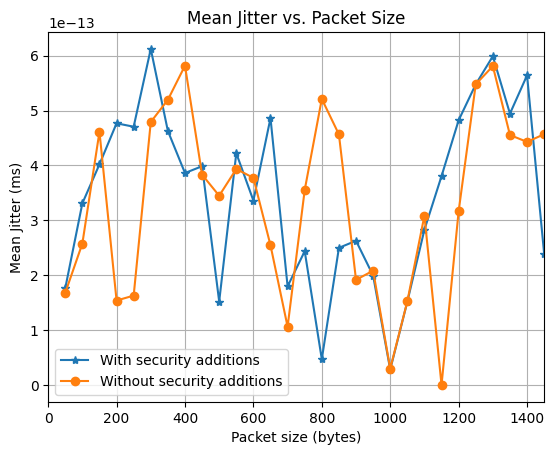

In [29]:
plt.figure(dpi=400)
fig, ax = plt.subplots()

ax.plot(packet_sizes, secure_datas.mean_jitter() * 1000, '*-', label="With security additions")
ax.plot(packet_sizes, insecure_datas.mean_jitter() * 1000, 'o-', label="Without security additions")
ax.set_xlabel("Packet size (bytes)")
ax.set_ylabel("Mean Jitter (ms)")
ax.set_title("Mean Jitter vs. Packet Size")
ax.set_xbound(0, max(packet_sizes))
ax.grid()
ax.legend()
plt.show()

fig.savefig(f"{BASE_DIRECTORY}/jitter.png")

This shows the mean jitter of the flow for various packet sizes. The result is essentially
random noise at a miniscule (1e-13) scale because the current network does not impose
any variation in the latency - these are likely floating point errors. 

<Figure size 2560x1920 with 0 Axes>

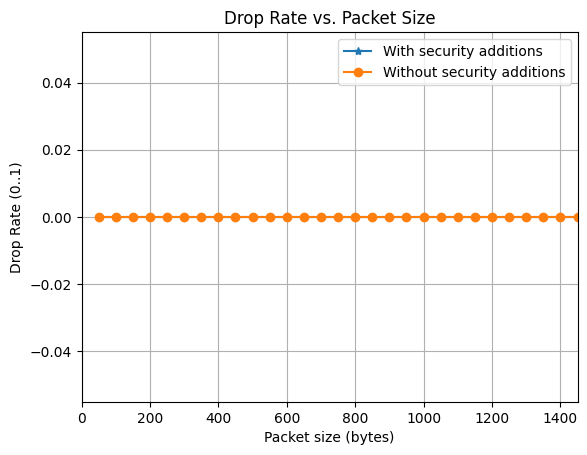

In [30]:

plt.figure(dpi=400)
fig, ax = plt.subplots()

ax.plot(packet_sizes, secure_datas.drop_rate(), '*-', label="With security additions")
ax.plot(packet_sizes, insecure_datas.drop_rate(), 'o-', label="Without security additions")
ax.set_xlabel("Packet size (bytes)")
ax.set_ylabel("Drop Rate (0..1)")
ax.set_title("Drop Rate vs. Packet Size")
ax.set_xbound(0, max(packet_sizes))
ax.grid()
ax.legend()
plt.show()

fig.savefig(f"{BASE_DIRECTORY}/drop_rate.png")

This shows the drop rate of the flow based on packet size. No packets are dropped in this simulation,
as the network can handle it and we have not simulated an error model along the transmission lines. 

There is no overloading of queues here.

**It is worth noting that if we include the initial ARP transmissions, smaller packet sizes
do have some dropped packets because they send more at a time, which overloads the ARP queue 
at the beginning of the transmission.**